In [1]:
import torch
import torch.nn as nn
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import torchmetrics
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
N_SAMPLES = 1000
X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state = 42)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

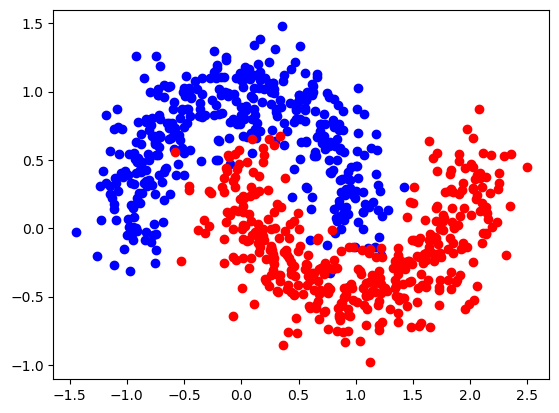

In [5]:
plt.plot(X_train[y_train==0, 0], X_train[y_train==0, 1], 'bo')
plt.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], 'ro')
plt.show()

In [6]:
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [7]:
len(X_train), len(X_test)

(800, 200)

In [8]:
X_train[0:5]

tensor([[ 2.1397,  0.3731],
        [-1.2067,  0.4169],
        [-0.2117,  1.1715],
        [-0.0632,  0.9842],
        [ 0.3938, -0.1620]], device='cuda:0')

In [9]:
y_train[0:5]

tensor([1, 0, 0, 0, 1], device='cuda:0')

In [10]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(2, 16)
        self.linear2 = nn.Linear(16, 8)
        self.linear3 = nn.Linear(8, 4)
        self.linear4 = nn.Linear(4, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        return x

In [11]:
model = BinaryClassifier().to(device)

In [12]:
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.2665,  0.0347],
                      [ 0.6534, -0.2719],
                      [-0.7025, -0.2625],
                      [-0.3305, -0.0606],
                      [ 0.1534,  0.3511],
                      [-0.3138,  0.6171],
                      [ 0.2310, -0.2780],
                      [ 0.0548, -0.6825],
                      [ 0.5183,  0.3941],
                      [-0.6371,  0.1286],
                      [ 0.5600,  0.2187],
                      [-0.1725, -0.1101],
                      [-0.4748,  0.2451],
                      [ 0.3589, -0.5272],
                      [ 0.0014,  0.1721],
                      [ 0.2380, -0.4901]], device='cuda:0')),
             ('linear1.bias',
              tensor([ 0.2782,  0.1215,  0.6663,  0.1379,  0.3332,  0.0039, -0.5718,  0.5571,
                      -0.0461, -0.6041,  0.2425,  0.4294, -0.0447,  0.2938, -0.1606,  0.4320],
                     device='cuda:0')),
             ('li

In [13]:
model.eval()

with torch.inference_mode():
    y_pred = model(X_train)


In [14]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
EPOCHS = 1000

In [16]:
epoch_count = np.arange(1, EPOCHS+1)
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

In [17]:
for epoch in range(EPOCHS):

    model.train()

    y_logits = model(X_train)
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_function(y_logits, y_train.view(-1, 1).float()) 
    accuracy = torchmetrics.functional.accuracy(y_pred.squeeze(), y_train.squeeze(), task = "binary")
    train_loss.append(loss.item())
    train_accuracy.append(accuracy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        y_logits = model(X_test)
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_function(y_logits, y_test.view(-1, 1).float())
        accuracy = torchmetrics.functional.accuracy(y_pred.squeeze(), y_test.squeeze(), task = "binary")
        test_loss.append(loss.item())
        test_accuracy.append(accuracy)

    if epoch % 100 == 0:
        print(f'Epoch {epoch} | Train Loss: {train_loss[-1]} | Test Loss: {test_loss[-1]} | Train Accuracy: {train_accuracy[-1]} | Test Accuracy: {test_accuracy[-1]}')


Epoch 0 | Train Loss: 0.7366616725921631 | Test Loss: 0.7243225574493408 | Train Accuracy: 0.5 | Test Accuracy: 0.5
Epoch 100 | Train Loss: 0.2705900967121124 | Test Loss: 0.24988242983818054 | Train Accuracy: 0.9599999785423279 | Test Accuracy: 0.9850000143051147
Epoch 200 | Train Loss: 0.14013300836086273 | Test Loss: 0.13484132289886475 | Train Accuracy: 0.9750000238418579 | Test Accuracy: 0.9750000238418579
Epoch 300 | Train Loss: 0.10532113909721375 | Test Loss: 0.10003291815519333 | Train Accuracy: 0.9762499928474426 | Test Accuracy: 0.9800000190734863
Epoch 400 | Train Loss: 0.08843106031417847 | Test Loss: 0.08466342836618423 | Train Accuracy: 0.981249988079071 | Test Accuracy: 0.9800000190734863
Epoch 500 | Train Loss: 0.08009614795446396 | Test Loss: 0.07348176091909409 | Train Accuracy: 0.9775000214576721 | Test Accuracy: 0.9850000143051147
Epoch 600 | Train Loss: 0.07241924852132797 | Test Loss: 0.07318920642137527 | Train Accuracy: 0.981249988079071 | Test Accuracy: 0.9700

In [18]:
from helper_functions import plot_decision_boundary

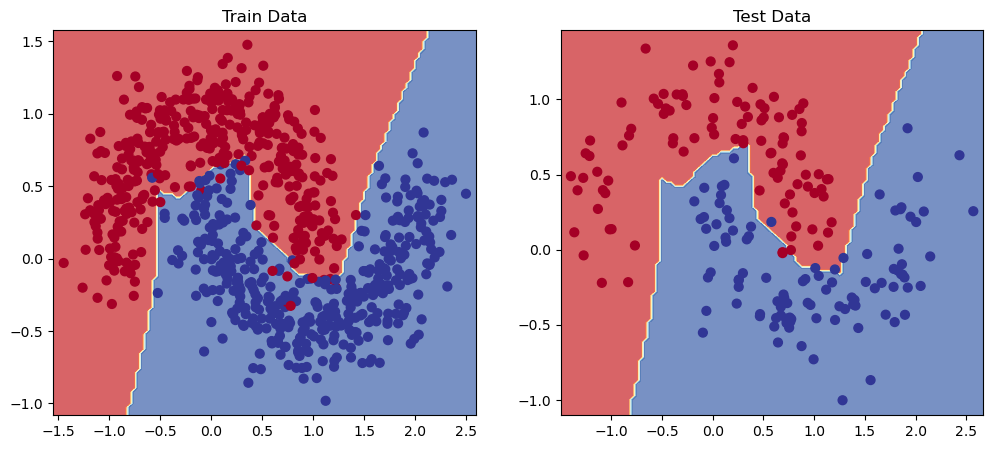

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_decision_boundary(model, X_train, y_train)
plt.title('Train Data')
plt.subplot(1, 2, 2)
plot_decision_boundary(model, X_test, y_test)
plt.title('Test Data')
plt.show()

## Multi-class Problem

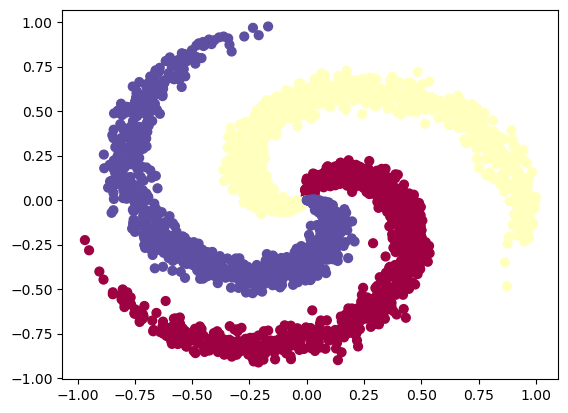

In [47]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 1000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
X_train = torch.FloatTensor(X_train).to(device).float()
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device).float()
y_test = torch.LongTensor(y_test).to(device)

In [50]:
len(X_train), len(X_test)

(2400, 600)

In [51]:
in_features = X_train.shape[1]
out_features = torch.unique(y_train).shape[0]

in_features, out_features

(2, 3)

In [52]:
class MultiClass(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear1 = nn.Linear(in_features, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 16)
        self.linear4 = nn.Linear(16, out_features)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        x = self.softmax(x)
        return x


In [53]:
model = MultiClass(in_features, out_features).to(device)

In [54]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [55]:
EPOCHS = 1000

In [56]:
epoch_count = np.arange(1, EPOCHS+1)
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

In [62]:
for epoch in range(EPOCHS):

    model.train()

    y_logits = model(X_train)
    loss = loss_function(y_logits, y_train.long())  # Ensure labels are in long format
    train_loss.append(loss.item())
    accuracy = torchmetrics.functional.accuracy(y_logits.argmax(dim=1), y_train, task="multiclass", num_classes=out_features)

    train_accuracy.append(accuracy.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        y_logits = model(X_test)
        _, y_pred = torch.max(y_logits, 1)

        loss = loss_function(y_logits, y_test.long())  # Ensure labels are in long format
        accuracy = torchmetrics.functional.accuracy(y_pred, y_test, task="multiclass", num_classes=out_features)

        test_loss.append(loss.item())
        test_accuracy.append(accuracy.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch} | Train Loss: {train_loss[-1]} | Test Loss: {test_loss[-1]} | Train Accuracy: {train_accuracy[-1]} | Test Accuracy: {test_accuracy[-1]}')


Epoch 0 | Train Loss: 1.0910592079162598 | Test Loss: 1.0844380855560303 | Train Accuracy: 0.4795833230018616 | Test Accuracy: 0.4933333396911621
Epoch 100 | Train Loss: 0.560702383518219 | Test Loss: 0.5576568245887756 | Train Accuracy: 0.997083306312561 | Test Accuracy: 0.9983333349227905
Epoch 200 | Train Loss: 0.5564246773719788 | Test Loss: 0.5552211403846741 | Train Accuracy: 0.9987499713897705 | Test Accuracy: 0.9983333349227905
Epoch 300 | Train Loss: 0.5550665855407715 | Test Loss: 0.5545191168785095 | Train Accuracy: 0.9987499713897705 | Test Accuracy: 0.9983333349227905
Epoch 400 | Train Loss: 0.554408848285675 | Test Loss: 0.5541671514511108 | Train Accuracy: 0.9987499713897705 | Test Accuracy: 0.9983333349227905
Epoch 500 | Train Loss: 0.5539529323577881 | Test Loss: 0.5539112687110901 | Train Accuracy: 0.9987499713897705 | Test Accuracy: 0.9983333349227905
Epoch 600 | Train Loss: 0.553737998008728 | Test Loss: 0.5537947416305542 | Train Accuracy: 0.9987499713897705 | Test

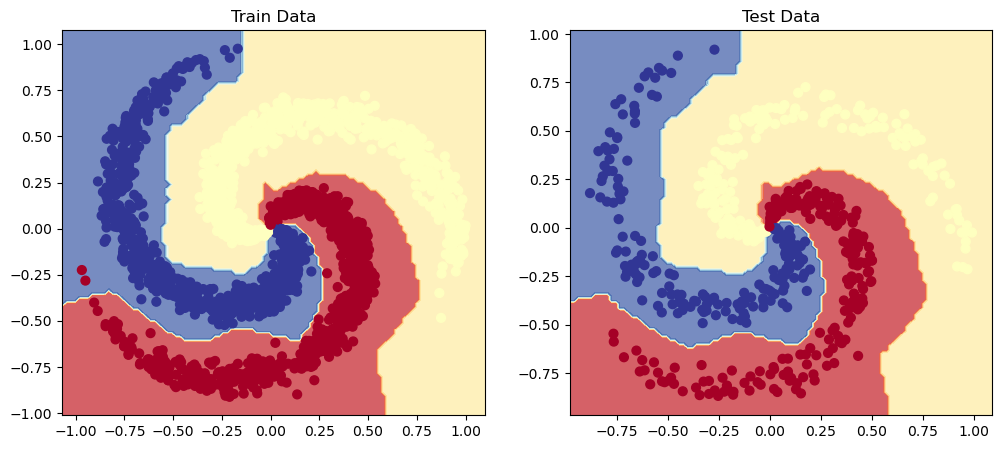

In [63]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_decision_boundary(model, X_train, y_train)
plt.title('Train Data')
plt.subplot(1, 2, 2)
plot_decision_boundary(model, X_test, y_test)
plt.title('Test Data')
plt.show()